# Reinforcement learning

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from agents import BlackjackMC, MountainCarQ, BlackjackDQ

## Blackjack

In [2]:
env = gym.make("Blackjack-v1", render_mode="human", sab=True) # sab=True -> wersja z obsługą „natural blackjack” i dokładną specyfiką polityk
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)

    print(f"State: {observation}, Action: {action}, Reward: {reward}")

    episode_over = terminated or truncated

env.close()

State: (12, 7, 0), Action: 0, Reward: -1.0


### Wczytanie modelu

In [3]:
env = gym.make("Blackjack-v1", sab=True)
agent = BlackjackMC(env)
agent.load_model('models/mc_blackjack.pkl')

### Testy

##### Krzywa uczenia

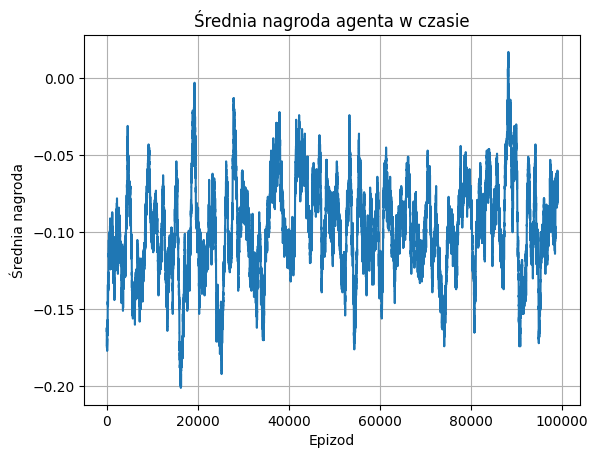

In [4]:
with open('history/mc_blackjack_history.pkl', 'rb') as file:
    agent_reward_history = pickle.load(file)
rolling_avg = np.convolve(agent_reward_history, np.ones(1000)/1000, mode='valid')
plt.plot(rolling_avg)
plt.title("Średnia nagroda agenta w czasie")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.show()

##### Polityka podejmowania decyzji

In [5]:
usable_ace = np.zeros((21 - 3, 10))  # player sum 4-21, dealer 1-10
no_usable_ace = np.zeros((21 - 3, 10))

for player in range(4, 22):
    for dealer in range(1, 11):
        state = (player, dealer, 1)
        usable_ace[player - 4, dealer - 1] = agent.get_action(state)

        state = (player, dealer, 0)
        no_usable_ace[player - 4, dealer - 1] = agent.get_action(state)

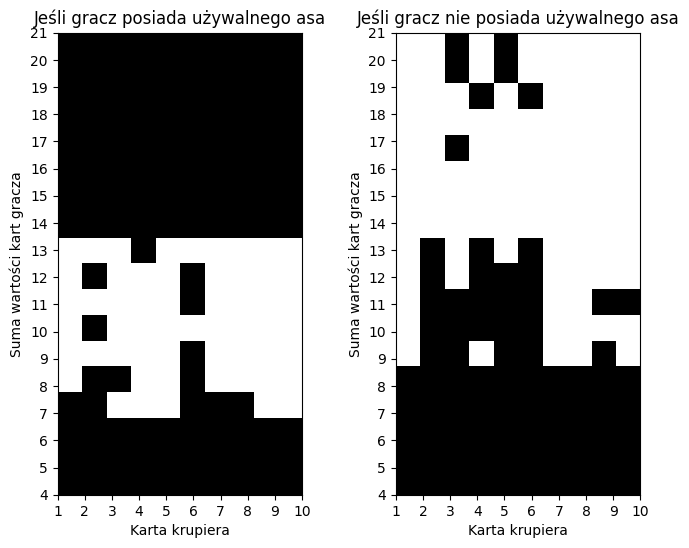

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 6)

ax1.imshow(usable_ace, cmap='gray', extent=[1, 10, 4, 21])
ax1.set_title('Jeśli gracz posiada używalnego asa')
ax1.set_xlabel("Karta krupiera")
ax1.set_xticks(ticks=np.arange(1, 11, 1))
ax1.set_ylabel("Suma wartości kart gracza")
ax1.set_yticks(ticks=np.arange(4, 22, 1))

ax2.imshow(no_usable_ace, cmap='gray', extent=[1, 10, 4, 21])
ax2.set_title('Jeśli gracz nie posiada używalnego asa')
ax2.set_xlabel("Karta krupiera")
ax2.set_xticks(ticks=np.arange(1, 11, 1))
ax2.set_ylabel("Suma wartości kart gracza")
_ = ax2.set_yticks(ticks=np.arange(4, 22, 1))

##### Performance agenta

In [7]:
def simulate(num_episodes: int, policy):
    wins, draws, losses = 0, 0, 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
        if reward == 1:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    return wins, draws, losses

In [8]:
num_episodes = 1000
wins, draws, losses = simulate(num_episodes, agent.get_action)
print("Wytrenowany agent:")
print(f"Wygrane: {wins} ({(wins / num_episodes * 100):.2f}%)")
print(f"Remisy: {draws} ({(draws / num_episodes * 100):.2f}%)")
print(f"Przegrane: {losses} ({(losses / num_episodes * 100):.2f}%)")

Wytrenowany agent:
Wygrane: 453 (45.30%)
Remisy: 95 (9.50%)
Przegrane: 452 (45.20%)


In [9]:
num_episodes = 1000
wins, draws, losses = simulate(num_episodes, lambda _: env.action_space.sample())
print("Losowy agent:")
print(f"Wygrane: {wins} ({(wins / num_episodes * 100):.2f}%)")
print(f"Remisy: {draws} ({(draws / num_episodes * 100):.2f}%)")
print(f"Przegrane: {losses} ({(losses / num_episodes * 100):.2f}%)")

Losowy agent:
Wygrane: 279 (27.90%)
Remisy: 46 (4.60%)
Przegrane: 675 (67.50%)


## Mountain Car

In [10]:
env = gym.make("MountainCarContinuous-v0", render_mode="human")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    episode_over = terminated or truncated

env.close()

### Wczytanie modelu

In [11]:
env = gym.make("MountainCarContinuous-v0")
agent = MountainCarQ(env, position_bins=10, velocity_bins=5, action_bins=10)
agent.load_model('models/q_mountain_car.pkl')

### Testy

##### Wizualne sprawdzenie działania agenta

In [12]:
env = gym.make("MountainCarContinuous-v0", render_mode="human")
observation, _ = env.reset()
episode_over = False
while not episode_over:
    action = agent.get_action(observation)
    next_observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated
    observation = next_observation

env.close()

##### Krzywa uczenia

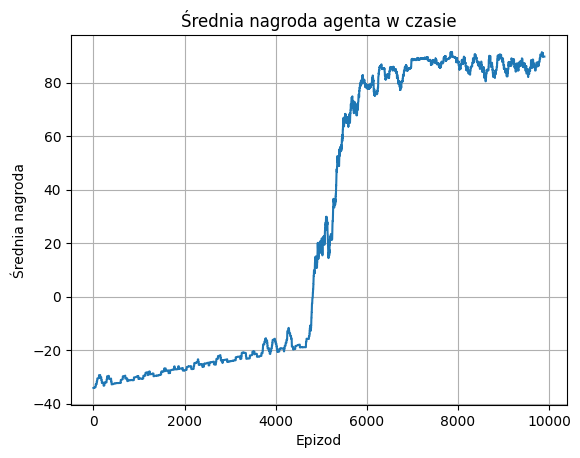

In [13]:
with open('history/q_mountain_car_history.pkl', 'rb') as file:
    agent_reward_history = pickle.load(file)
rolling_avg = np.convolve(agent_reward_history, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg)
plt.title("Średnia nagroda agenta w czasie")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.show()

### Porównanie trzech współczynników dyskontowych

In [14]:
env = gym.make("MountainCarContinuous-v0")
agent2 = MountainCarQ(env, position_bins=10, velocity_bins=5, action_bins=10)
agent2.load_model('models/q_mountain_car_2.pkl')

In [15]:
env = gym.make("MountainCarContinuous-v0", render_mode="human")
observation, _ = env.reset()
episode_over = False
while not episode_over:
    action = agent2.get_action(observation)
    next_observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated
    observation = next_observation

env.close()

In [16]:
env = gym.make("MountainCarContinuous-v0")
agent3 = MountainCarQ(env, position_bins=10, velocity_bins=5, action_bins=10)
agent3.load_model('models/q_mountain_car_3.pkl')

In [17]:
env = gym.make("MountainCarContinuous-v0", render_mode="human")
observation, _ = env.reset()
episode_over = False
while not episode_over:
    action = agent3.get_action(observation)
    next_observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated
    observation = next_observation

env.close()

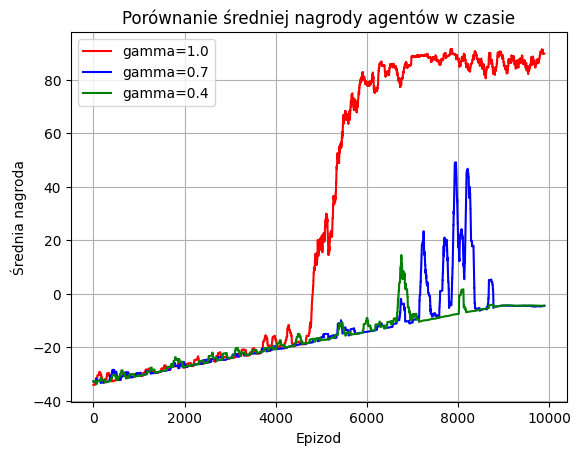

In [18]:
with open('history/q_mountain_car_2_history.pkl', 'rb') as file:
    agent2_reward_history = pickle.load(file)

with open('history/q_mountain_car_3_history.pkl', 'rb') as file:
    agent3_reward_history = pickle.load(file)

rolling_avg1 = np.convolve(agent_reward_history, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg1, 'r', label='gamma=1.0')

rolling_avg2 = np.convolve(agent2_reward_history, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg2, 'b', label='gamma=0.7')

rolling_avg3 = np.convolve(agent3_reward_history, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg3, 'g', label='gamma=0.4')

plt.title("Porównanie średniej nagrody agentów w czasie")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.legend()
plt.show()

## Blackjack, ciąg dalszy

### Wczytanie modelu

In [19]:
env = gym.make("Blackjack-v1", sab=True)
agent = BlackjackDQ(env)
agent.load_model('models/deep_q_blackjack.pt')

### Testy

##### Krzywa uczenia

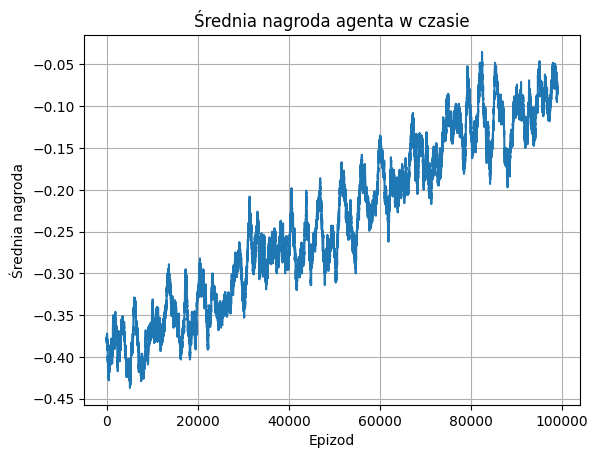

In [20]:
with open('history/deep_q_blackjack_history.pkl', 'rb') as file:
    agent_reward_history = pickle.load(file)

rolling_avg = np.convolve(agent_reward_history, np.ones(1000)/1000, mode='valid')
plt.plot(rolling_avg)
plt.title("Średnia nagroda agenta w czasie")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.show()

##### Polityka podejmowania decyzji

In [21]:
usable_ace = np.zeros((21 - 3, 10))  # player sum 4-21, dealer 1-10
no_usable_ace = np.zeros((21 - 3, 10))

for player in range(4, 22):
    for dealer in range(1, 11):
        state = (player, dealer, 1)
        usable_ace[player - 4, dealer - 1] = agent.get_action(state)

        state = (player, dealer, 0)
        no_usable_ace[player - 4, dealer - 1] = agent.get_action(state)

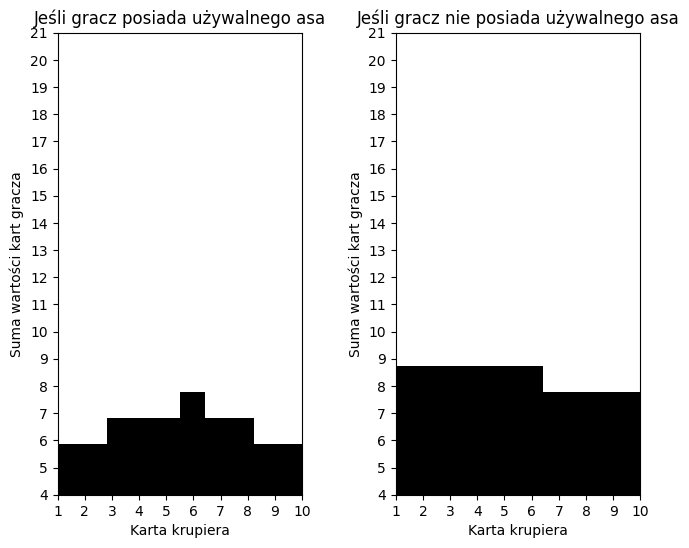

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 6)

ax1.imshow(usable_ace, cmap='gray', extent=[1, 10, 4, 21])
ax1.set_title('Jeśli gracz posiada używalnego asa')
ax1.set_xlabel("Karta krupiera")
ax1.set_xticks(ticks=np.arange(1, 11, 1))
ax1.set_ylabel("Suma wartości kart gracza")
ax1.set_yticks(ticks=np.arange(4, 22, 1))

ax2.imshow(no_usable_ace, cmap='gray', extent=[1, 10, 4, 21])
ax2.set_title('Jeśli gracz nie posiada używalnego asa')
ax2.set_xlabel("Karta krupiera")
ax2.set_xticks(ticks=np.arange(1, 11, 1))
ax2.set_ylabel("Suma wartości kart gracza")
_ = ax2.set_yticks(ticks=np.arange(4, 22, 1))

##### Performance agenta

In [23]:
num_episodes = 1000
wins, draws, losses = simulate(num_episodes, agent.get_action)
print("Wytrenowany agent:")
print(f"Wygrane: {wins} ({(wins / num_episodes * 100):.2f}%)")
print(f"Remisy: {draws} ({(draws / num_episodes * 100):.2f}%)")
print(f"Przegrane: {losses} ({(losses / num_episodes * 100):.2f}%)")

Wytrenowany agent:
Wygrane: 402 (40.20%)
Remisy: 93 (9.30%)
Przegrane: 505 (50.50%)
